In [1]:
import sys
import numpy as np
import spectral as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('../')
from preprocessing import *
from extinctions import *
from plotting_parameters import *

### Load a HeliCoid image

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


(<Figure size 500x500 with 1 Axes>, <Axes: >)

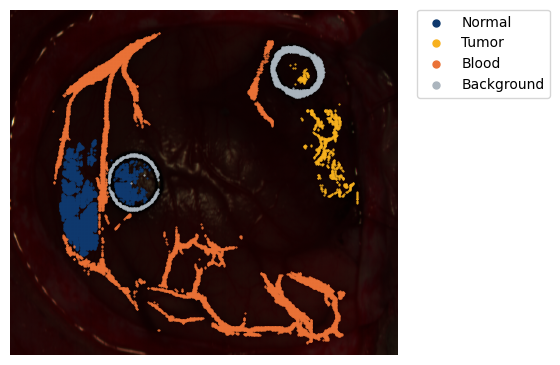

In [2]:
data_folder = "../../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)

In [3]:
img_data = get_array(img)
img_data = img_data.astype(np.float32)
img_data_norm = img_data / np.linalg.norm(img_data, axis=(0,1), keepdims=True)

img_data_proj = project_img(img_data, white_ref, dark_ref)

### Load extinction spectra of endmembers

array([-45.51465554, -49.32499628, -52.45758503, -54.21793252,
       -54.55514621, -53.30562154, -50.51943858, -46.81759807,
       -42.02064972, -36.75878197, -31.19142055, -26.69412913,
       -21.38802026, -16.76552428, -12.68390664,  -9.20075523,
        -6.02310188,  -3.39300466,  -1.0333433 ,   0.86974315,
         2.31124799,   3.52655369,   4.57158146,   5.407939  ,
         5.99305296,   6.48384904,   6.91037393,   7.20585423,
         7.42370559,   7.58980909,   7.71918699,   7.79430818,
         7.89113272,   7.94037834,   7.99129395,   8.03135844,
         8.04387956,   8.0639118 ,   8.07810182,   8.11065463,
         8.10815018,   8.09729961,   8.12651299,   8.14320744,
         8.16340657,   8.17884881,   8.18677771,   8.21140162,
         8.22475608,   8.20004928,   8.16666202,   8.14128711,
         8.11733186,   8.07901971,   8.036033  ,   7.98862372,
         7.92693988,   7.86542403,   7.78253917,   7.68287806,
         7.59289874,   7.46961451,   7.33481325,   7.18

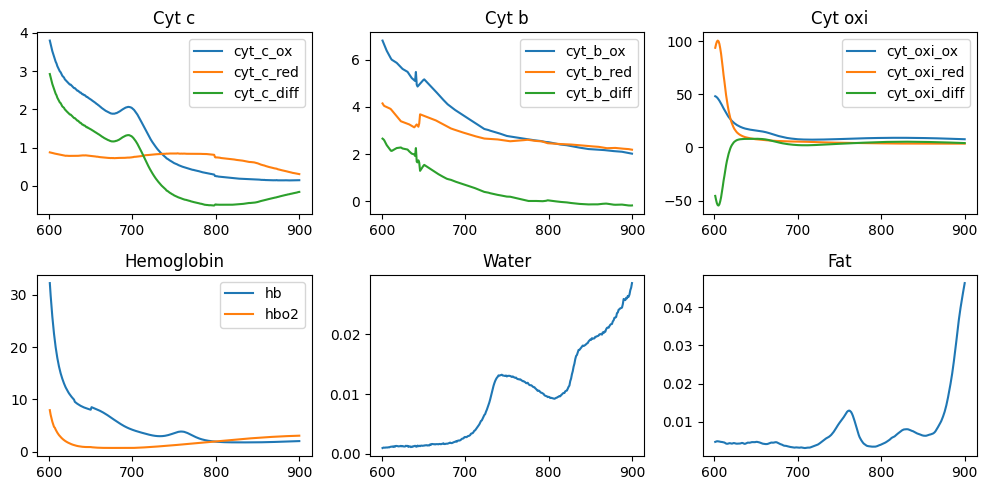

In [4]:
bands_range = [601,900]

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
specular = np.ones_like(water)


# Cut bands of the image
img_interp, band_centers_interp = bands_lin_interpolation(img, img.bands.centers, bands_range)
img_cut, band_centers = band_removal(img_interp, bands_range, band_centers_interp)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
white_ref_cut, _ = band_removal(white_ref_interp, bands_range, band_centers_interp)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
dark_ref_cut, _ = band_removal(dark_ref_interp, bands_range, band_centers_interp)
img_calib = calibrate_img(img_cut, white_ref_cut, dark_ref_cut)


# Plot the extinctions
fig, axs = plt.subplots(2,3, figsize=(10,5))   
for name, extinction in extinction_dict.items():
    if "cyt_c" in name:
        axs[0,0].plot(band_centers, extinction, label=name)
    elif "cyt_b" in name: 
        axs[0,1].plot(band_centers, extinction, label=name)
    elif "cyt_oxi" in name: 
        axs[0,2].plot(band_centers, extinction, label=name)
    elif name == "hb":
        axs[1,0].plot(band_centers, extinction, label=name)
    elif name == "hbo2":
        axs[1,0].plot(band_centers, extinction, label=name)
    elif name == "water":
        axs[1,1].plot(band_centers, extinction, label=name)
    elif name == "fat":
        axs[1,2].plot(band_centers, extinction, label=name)
axs[0,0].set_title("Cyt c")
axs[0,1].set_title("Cyt b")
axs[0,2].set_title("Cyt oxi")
axs[1,0].set_title("Hemoglobin")
axs[1,1].set_title("Water")
axs[1,2].set_title("Fat")
axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
plt.tight_layout()


# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")

### Unmixing projected data

In [16]:
import torch

def LMM(M, img, endmember_labels=None, plot=False):
    M_inv = np.linalg.pinv(M)

    c = np.einsum("ij,klj->kli", M_inv, -img)

    if plot:
        N = c.shape[2]
        if N == 1:
            plt.figure()
            plt.imshow(c[:,:,0], cmap="gray")
            return
        fig, axs = plt.subplots(1,N, figsize=(15,5))
        for i in range(N):
            axs[i].imshow(c[:,:,i], cmap="gray")
            axs[i].set_title(endmember_labels[i])
        plt.tight_layout()

    return c


def project_img_spectr_lin(img, endmembers_proj, endmembers_unmix, device="cpu"):
    '''
    Project the image onto the subspace orthogonal to the spectra.
    input:
        img: image to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        endmembers: endmember spectra, shape (n, k), where n is the number of endmembers
    output:
        projected image perpendicular to all spectra, np.array
        projected endmembers_unmix, np.array
    '''

    img, endmembers_proj, endmembers_unmix = get_array(img), get_array(endmembers_proj), get_array(endmembers_unmix)
    img = torch.from_numpy(img).to(device).float()
    endmembers_proj = torch.from_numpy(endmembers_proj).to(device).float()
    endmembers_unmix = torch.from_numpy(endmembers_unmix).to(device).float()

    for n in range(endmembers_proj.shape[0]):
        endmember_proj = endmembers_proj[n,:]
        P = torch.eye(endmember_proj.shape[0]).to(device) - torch.outer(endmember_proj, endmember_proj)/torch.dot(endmember_proj, endmember_proj)
        
        # apply mapping to data
        img = torch.einsum('ij,...j->...i', P, img)
        endmembers_unmix = torch.einsum('ij,...j->...i', P, endmembers_unmix)
        endmembers_proj = torch.einsum('ij,...j->...i', P, endmembers_proj)

    # convert back to numpy array
    img_proj = img.cpu().numpy()
    endmembers_unmix_proj = endmembers_unmix.cpu().numpy()

    return img_proj, endmembers_unmix_proj


def project_img_spectr_bilinear(img, endmembers, device="cpu"):
    '''
    Project the image onto the subspace orthogonal to the spectra.
    input:
        img: image to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        endmembers: endmember spectra, shape (n, k), where n is the number of endmembers
    output:
        projected image perpendicular to all spectra, np.array
        projected endmembers_unmix, np.array
    '''

    img, endmembers = get_array(img), get_array(endmembers)
    img = torch.from_numpy(img).to(device).float()
    endmembers = torch.from_numpy(endmembers).to(device).float()

    for n in range(endmembers.shape[0]):
        for j in range(n, endmembers.shape[0]):

            endmember_proj_1 = endmembers[n,:]
            endmember_proj_2 = endmembers[j,:]
            endmember_proj_bilin = endmember_proj_1 * endmember_proj_2

            P_bilin = torch.eye(endmember_proj_bilin.shape[0]).to(device) - torch.outer(endmember_proj_bilin, endmember_proj_bilin)/torch.dot(endmember_proj_bilin, endmember_proj_bilin)
            
            # apply mapping to data
            img = torch.einsum('ij,...j->...i', P_bilin, img)
            endmembers = torch.einsum('ij,...j->...i', P_bilin, endmembers)

    # convert back to numpy array
    img_proj = img.cpu().numpy()
    endmembers_proj = endmembers.cpu().numpy()

    return img_proj, endmembers_proj


def distance_after_proj(img, endmember_array, idx):
    endmembers_unmix = endmember_array[idx,:][None,:]
    endmembers_proj = np.delete(endmember_array, idx, axis=0)
    img_proj, endmembers_unmix_proj = project_img_spectr_lin(img, endmembers_proj, endmembers_unmix, device="cuda")
    d = cosine_similarity(img_proj, endmembers_unmix_proj.squeeze())
    return d

In [11]:
def cosine_similarity(abs, spectr):
    return np.einsum("ijk,k->ij", abs, -spectr) / (np.linalg.norm(abs, axis=2) * np.linalg.norm(spectr))

### Projection + LMM

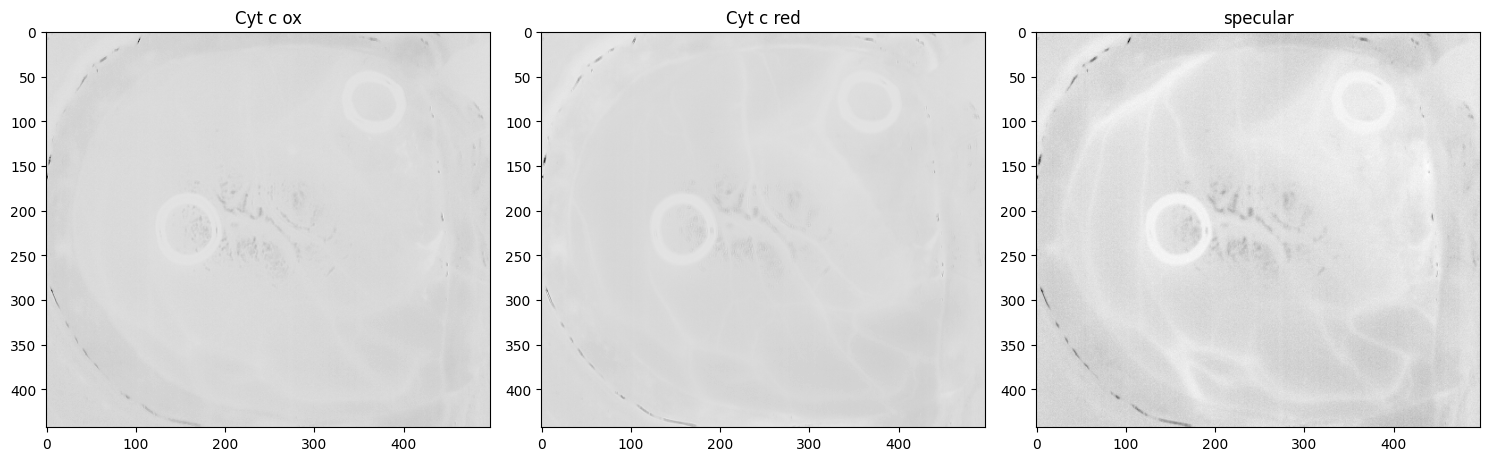

In [31]:
endmembers_proj = np.vstack((cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat))
endmembers_unmix = np.vstack((cyt_c_ox, cyt_c_red, specular))
img_proj, endmembers_unmix_proj = project_img_spectr_lin(img_cut, endmembers_proj, endmembers_unmix, device="cuda")

M = endmembers_unmix_proj.T
_ = LMM(M, img_proj, endmember_labels=["Cyt c ox", "Cyt c red", "specular"], plot=True)

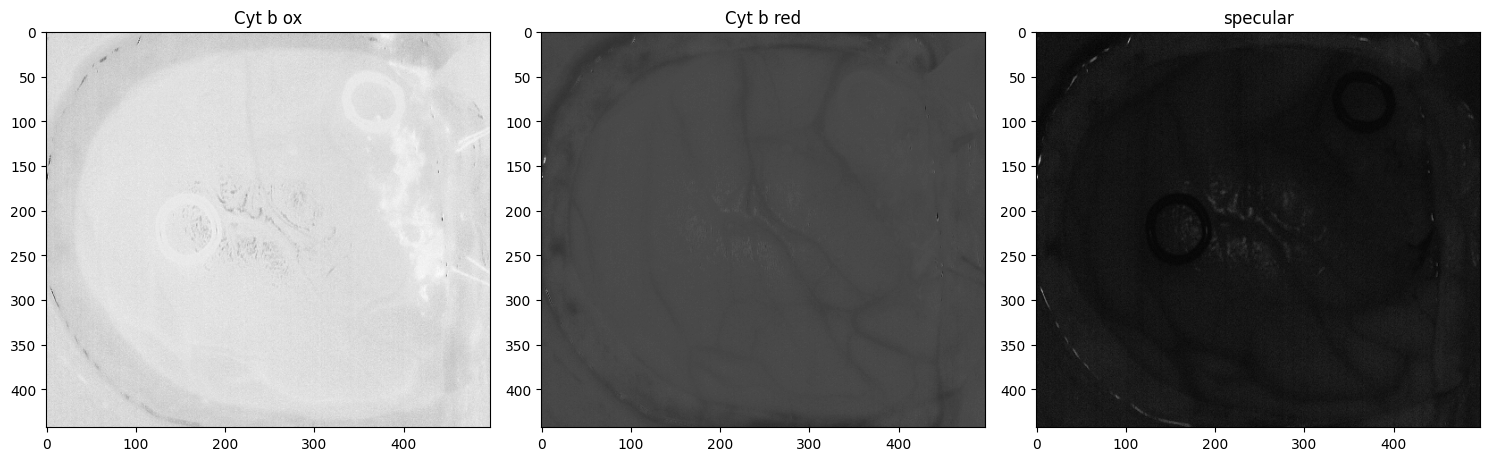

In [32]:
endmembers_proj = np.vstack((cyt_c_ox, cyt_c_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, specular))
endmembers_unmix = np.vstack((cyt_b_ox, cyt_b_red, specular))
img_proj, endmembers_unmix_proj = project_img_spectr_lin(img_cut, endmembers_proj, endmembers_unmix, device="cuda")

M = endmembers_unmix_proj.T
_ = LMM(M, img_proj, endmember_labels=["Cyt b ox", "Cyt b red", "specular"], plot=True)

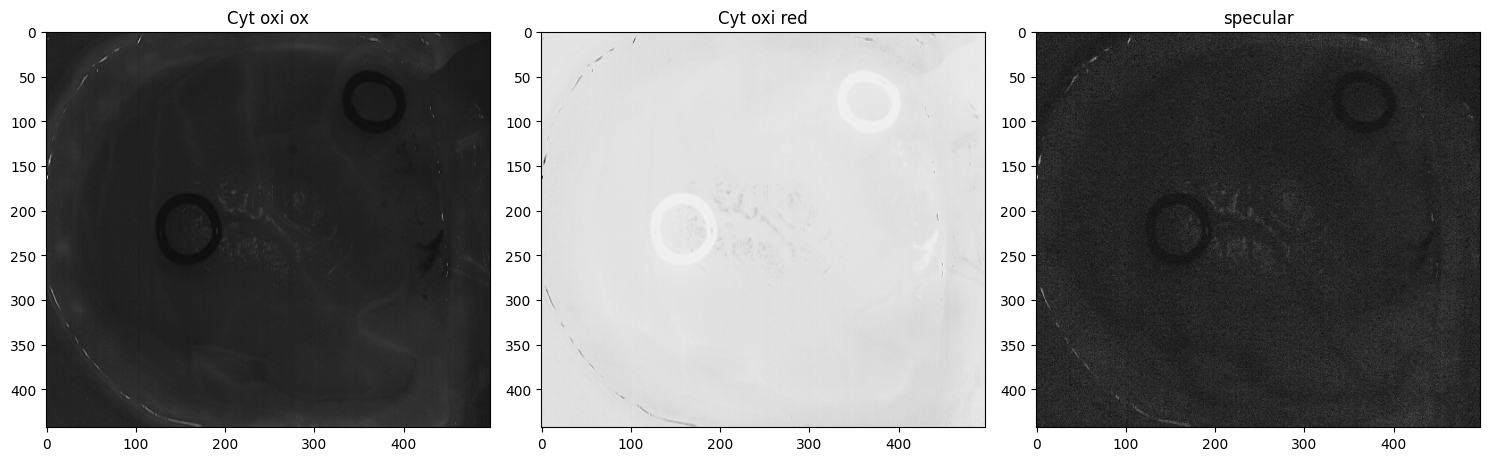

In [33]:
endmembers_proj = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, hb, hbo2, water, fat, specular))
endmembers_unmix = np.vstack((cyt_oxi_ox, cyt_oxi_red, specular))
img_proj, endmembers_unmix_proj = project_img_spectr_lin(img_cut, endmembers_proj, endmembers_unmix, device="cuda")

M = endmembers_unmix_proj.T
_ = LMM(M, img_proj, endmember_labels=["Cyt oxi ox", "Cyt oxi red", "specular"], plot=True)

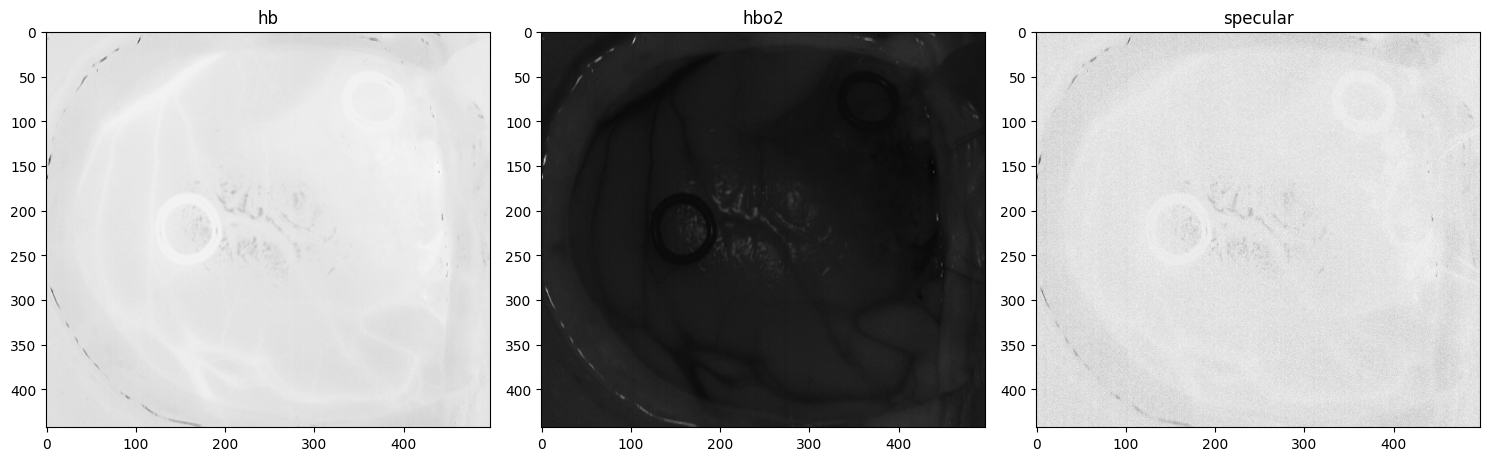

In [35]:
endmembers_proj = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, water, fat, specular))
endmembers_unmix = np.vstack((hb, hbo2, specular))
img_proj, endmembers_unmix_proj = project_img_spectr_lin(img_cut, endmembers_proj, endmembers_unmix, device="cuda")

M = endmembers_unmix_proj.T
_ = LMM(M, img_proj, endmember_labels=["hb", "hbo2", "specular"], plot=True)

### Projection (1st order) + Cosine similarity

/tmp/ipykernel_400149/2058377843.py:18: RuntimeWarning: divide by zero encountered in log
  d = distance_after_proj_2(np.log(img_calib), extinction_array, i)
/tmp/ipykernel_400149/2058377843.py:18: RuntimeWarning: invalid value encountered in log
  d = distance_after_proj_2(np.log(img_calib), extinction_array, i)


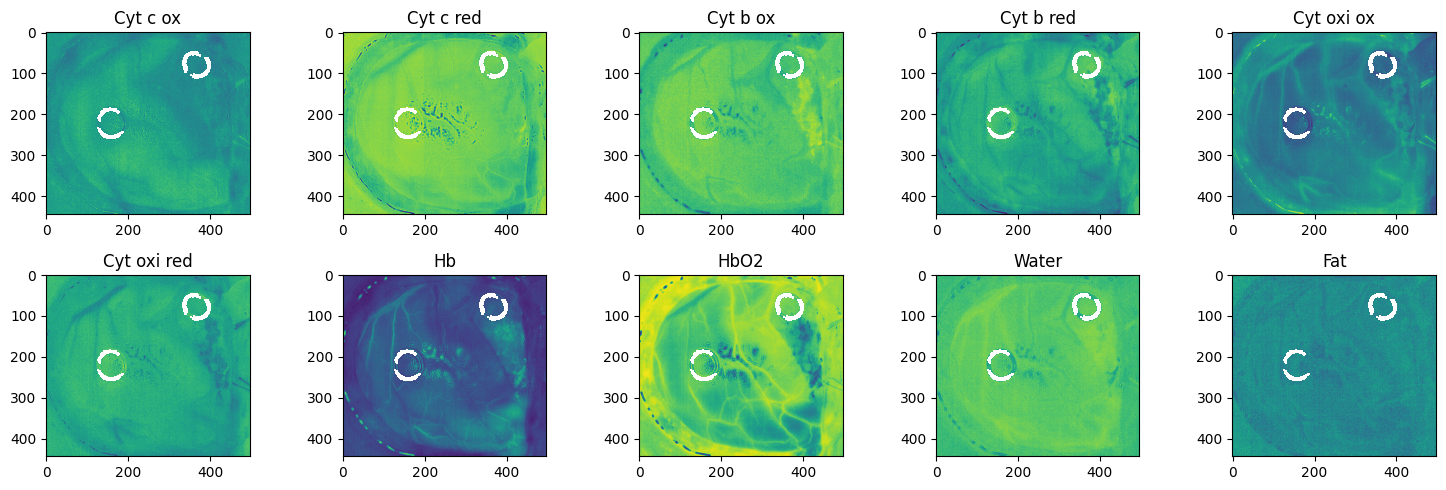

In [10]:
# fig, axs = plt.subplots(2,5, figsize=(15,5))
# endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "specular"]
# extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])

# for i in range(10):
#     d = distance_after_proj(np.log(img_calib), extinction_array, i)
#     axs[i//5,i%5].imshow(d)
#     axs[i//5,i%5].set_title(endmember_labels[i])
# plt.tight_layout()

# plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)

fig, axs = plt.subplots(2,5, figsize=(15,5))
endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "specular"]
extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])

for i in range(10):
    d = distance_after_proj_2(np.log(img_calib), extinction_array, i)
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
plt.tight_layout()

### Projection (2nd order) + Cosine similarity

/tmp/ipykernel_400149/538186263.py:6: RuntimeWarning: divide by zero encountered in log
  img_proj, endmembers_unmix_proj = project_img_spectr_bilinear(np.log(img_calib), extinction_array, device="cuda")
/tmp/ipykernel_400149/538186263.py:6: RuntimeWarning: invalid value encountered in log
  img_proj, endmembers_unmix_proj = project_img_spectr_bilinear(np.log(img_calib), extinction_array, device="cuda")


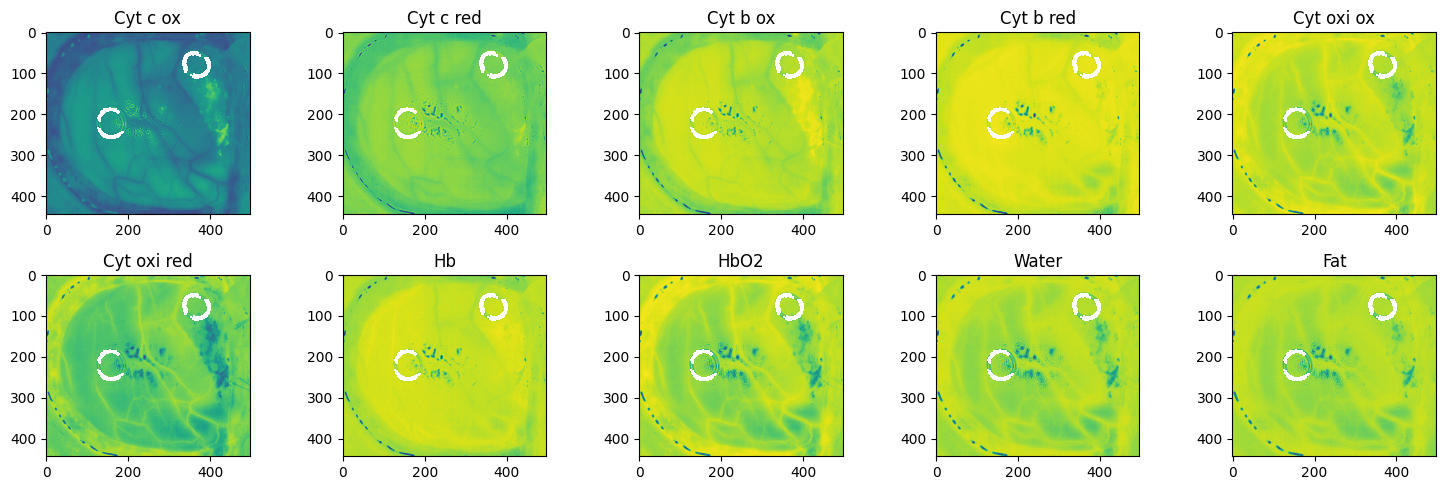

In [17]:
fig, axs = plt.subplots(2,5, figsize=(15,5))
endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "specular"]
extinction_dict_keys = list(extinction_dict.keys())

extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])
img_proj, endmembers_unmix_proj = project_img_spectr_bilinear(np.log(img_calib), extinction_array, device="cuda")
for i in range(10):
    d = cosine_similarity(img_proj, endmembers_unmix_proj[i,:])
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
plt.tight_layout()

### Projection (1st + 2nd order) + Projection

/tmp/ipykernel_400149/3272218270.py:6: RuntimeWarning: divide by zero encountered in log
  absorption_proj, endmembers_unmix_proj = project_img_spectr_bilinear(np.log(img_calib), extinction_array, device="cuda")
/tmp/ipykernel_400149/3272218270.py:6: RuntimeWarning: invalid value encountered in log
  absorption_proj, endmembers_unmix_proj = project_img_spectr_bilinear(np.log(img_calib), extinction_array, device="cuda")


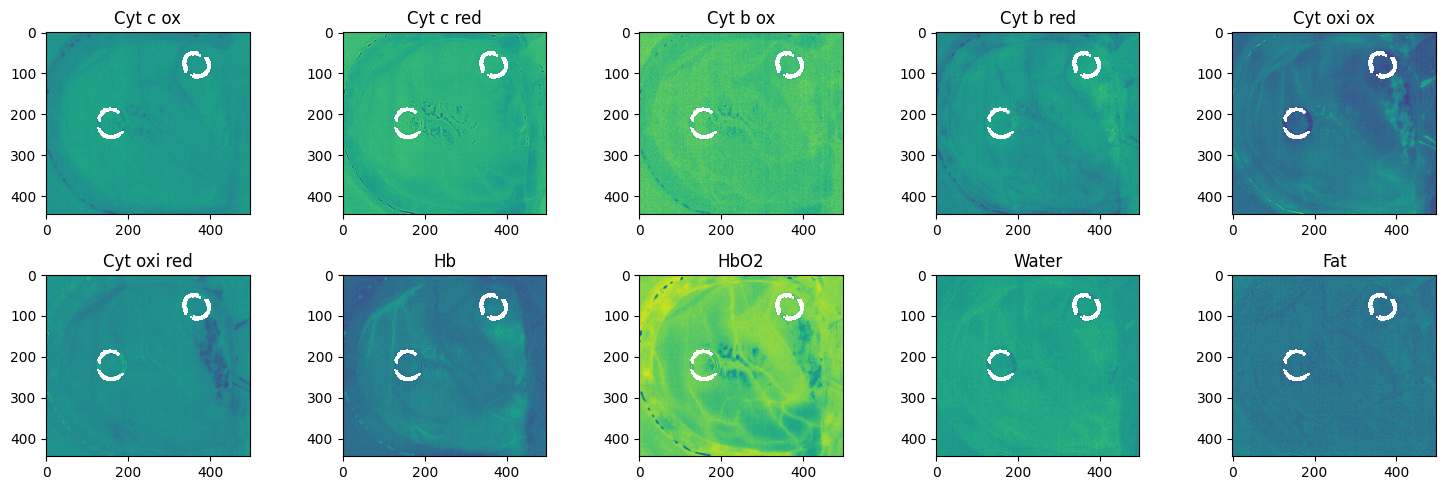

In [18]:
fig, axs = plt.subplots(2,5, figsize=(15,5))
endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "specular"]
extinction_dict_keys = list(extinction_dict.keys())

extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])
absorption_proj, endmembers_unmix_proj = project_img_spectr_bilinear(np.log(img_calib), extinction_array, device="cuda")

for i in range(10):
    d = distance_after_proj(absorption_proj, endmembers_unmix_proj, i)
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
plt.tight_layout()

### Cosine similarity without projection

/tmp/ipykernel_400149/840588801.py:5: RuntimeWarning: divide by zero encountered in log
  d = cosine_similarity(np.log(img_calib), extinction_dict[extinction_dict_keys[i]])
/tmp/ipykernel_400149/840588801.py:5: RuntimeWarning: invalid value encountered in log
  d = cosine_similarity(np.log(img_calib), extinction_dict[extinction_dict_keys[i]])
/tmp/ipykernel_400149/1077270778.py:2: RuntimeWarning: invalid value encountered in divide
  return np.einsum("ijk,k->ij", abs, -spectr) / (np.linalg.norm(abs, axis=2) * np.linalg.norm(spectr))


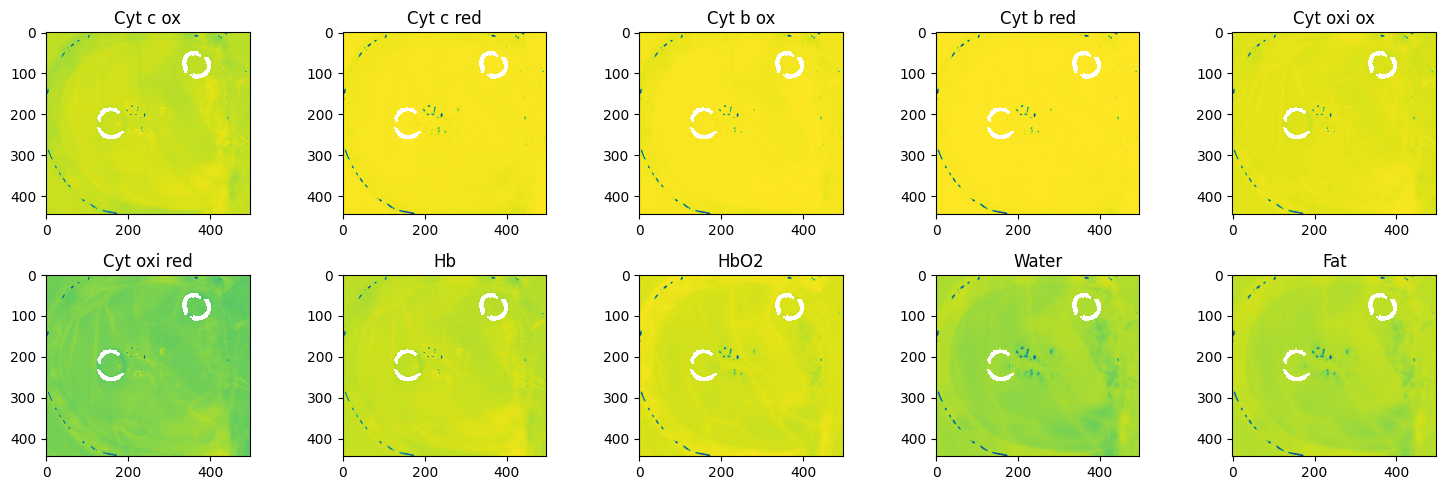

In [19]:
fig, axs = plt.subplots(2,5, figsize=(15,5))
endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "specular"]
extinction_dict_keys = list(extinction_dict.keys())
for i in range(10):
    d = cosine_similarity(np.log(img_calib), extinction_dict[extinction_dict_keys[i]])
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
plt.tight_layout()

### Unconstrained LMM

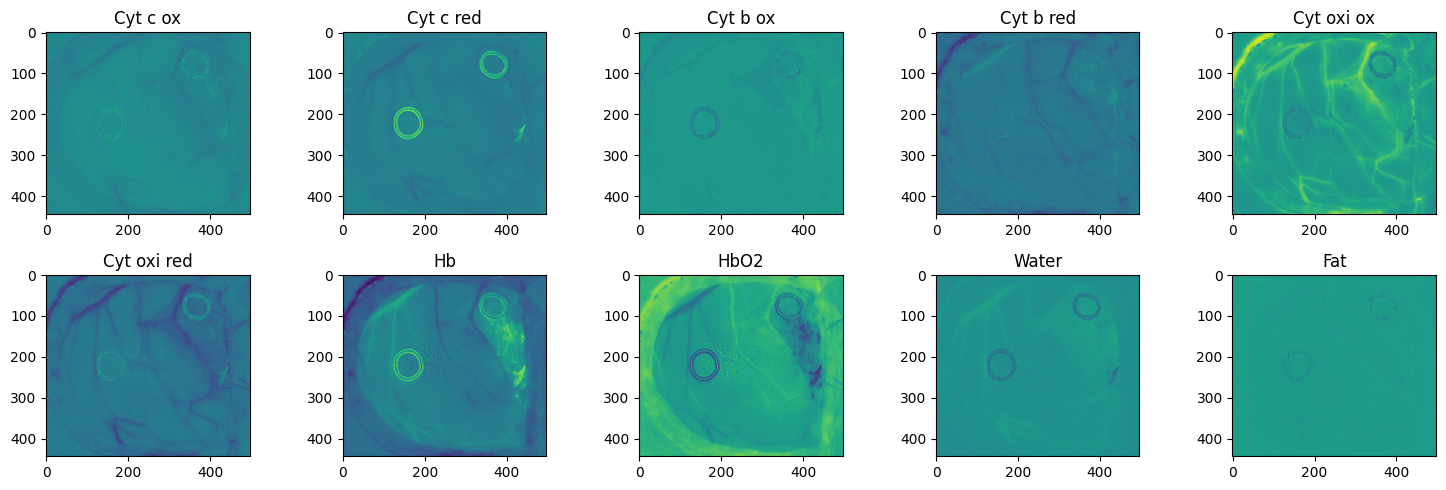

In [17]:
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=2, keepdims=True)

M = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, specular)).T
M = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat)).T

c = LMM(M, img_calib_norm)

fig, axs = plt.subplots(2,5, figsize=(15,5))
endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "specular"]
for i in range(10):
    axs[i//5,i%5].imshow(c[:,:,i])
    axs[i//5,i%5].set_title(endmember_labels[i])
plt.tight_layout()

# plt.figure()
# plt.imshow(c[:,:,10], cmap="gray")

fewer endmembers

-0.005611935114832617 -0.000607641295887752
0.0007706946100695241 0.0022108107482694994
-0.009152842552573287 0.006092674981333136
-0.02692120131838445 0.024303268057877723
-6.33189328133852 0.279852730007878
-2.1767555243428296 2.0398268627801706


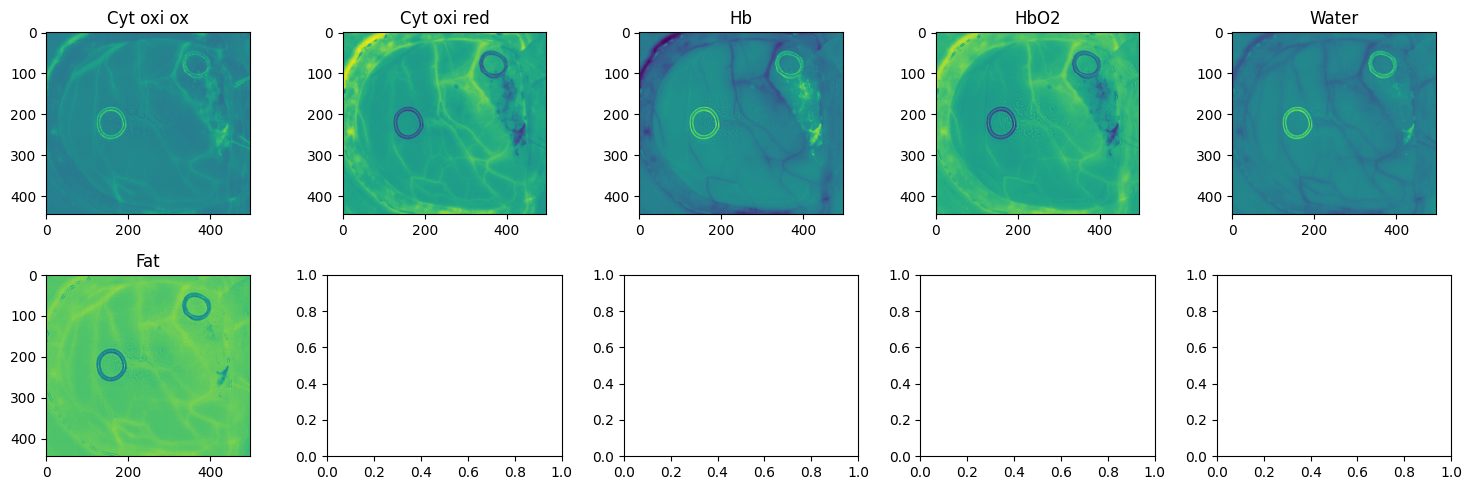

In [16]:
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=2, keepdims=True)

M = np.vstack((cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat)).T

c = LMM(M, img_calib_norm)

fig, axs = plt.subplots(2,5, figsize=(15,5))
endmember_labels = ["Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "specular"]
for i in range(6):
    axs[i//5,i%5].imshow(c[:,:,i])
    print(min(c[:,:,i].flatten()), max(c[:,:,i].flatten()))
    axs[i//5,i%5].set_title(endmember_labels[i])
plt.tight_layout()

after prjection (2nd order)

-3895.2046 678.41254
-3416.8079 257.44016
-876.0949 36.195347
-317.0036 799.28125
-43.99092 110.65429
-36.7806 9.858488


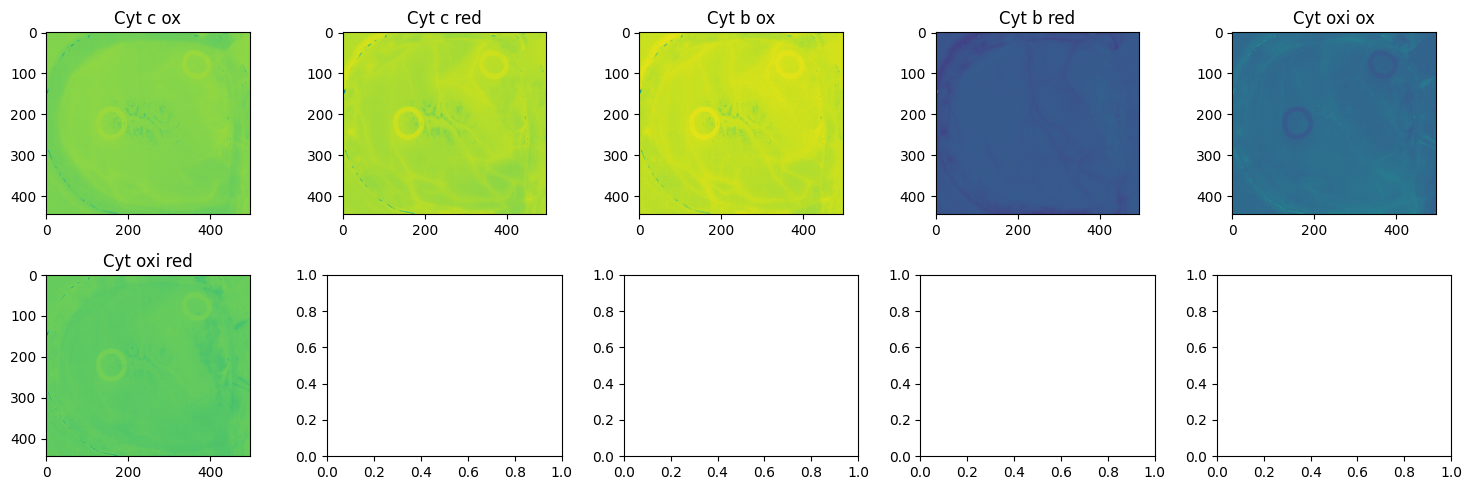

In [47]:
endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "specular"]

extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])
img_proj, endmembers_unmix_proj = project_img_spectr_bilinear(img_cut, extinction_array, device="cuda")

img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=2, keepdims=True)

M = endmembers_unmix_proj.T

c = LMM(M, img_proj)

fig, axs = plt.subplots(2,5, figsize=(15,5))
for i in range(6):
    axs[i//5,i%5].imshow(c[:,:,i])
    print(min(c[:,:,i].flatten()), max(c[:,:,i].flatten()))
    axs[i//5,i%5].set_title(endmember_labels[i])
plt.tight_layout()

In [13]:
import scipy 

def project_img_spectr_lin_2(img, endmembers_proj, endmembers_unmix, device="cpu"):
    '''
    Project the image onto the subspace orthogonal to the spectra.
    input:
        img: image to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        endmembers: endmember spectra, shape (n, k), where n is the number of endmembers
    output:
        projected image perpendicular to all spectra, np.array
        projected endmembers_unmix, np.array
    '''

    img, endmembers_proj, endmembers_unmix = get_array(img), get_array(endmembers_proj), get_array(endmembers_unmix)
    
    # construct projection matrix onto orthogonal complement of endmembers_proj
    endmembers_proj_orth = scipy.linalg.orth(endmembers_proj.T).T
    P = np.eye(endmembers_proj.shape[1]) - endmembers_proj_orth.T @ endmembers_proj_orth

    # convert to torch tensors
    P = torch.from_numpy(P).to(device).float()
    endmembers_proj = torch.from_numpy(endmembers_proj).to(device).float()
    img = torch.from_numpy(img).to(device).float()
    endmembers_unmix = torch.from_numpy(endmembers_unmix).to(device).float()

    # project data
    img_proj = torch.einsum('ij,...j->...i', P, img)
    endmembers_unmix_proj = torch.einsum('ij,...j->...i', P, endmembers_unmix)

    # convert back to numpy array
    img_proj = img_proj.cpu().numpy()
    endmembers_unmix_proj = endmembers_unmix_proj.cpu().numpy()

    return img_proj, endmembers_unmix_proj

def project_img_spectr_bilin_2(img, endmembers, device="cpu"):
    '''
    Project the image onto the subspace orthogonal to the spectra.
    input:
        img: image to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        endmembers: endmember spectra, shape (n, k), where n is the number of endmembers
    output:
        projected image perpendicular to all spectra, np.array
        projected endmembers_unmix, np.array
    '''

    img, endmembers = get_array(img), get_array(endmembers)
    
    n,m = endmembers.shape
    print(n,m)
    endmembers_bilin = np.zeros((int(n*(n+1)/2), m))
    for i in range(n):
        for j in range(i,n):
            endmembers_bilin[int(i*(i+1)/2+j),:] = endmembers[i,:] * endmembers[j,:]

    # construct projection matrix onto orthogonal complement of endmembers_bilin
    endmembers_bilin_orth = scipy.linalg.orth(endmembers_bilin.T).T
    print(endmembers_bilin_orth.shape)
    P = np.eye(m) - endmembers_bilin_orth.T @ endmembers_bilin_orth

    # convert to torch tensors
    P = torch.from_numpy(P).to(device).float()
    endmembers = torch.from_numpy(endmembers).to(device).float()
    img = torch.from_numpy(img).to(device).float()

    # project data
    img_proj = torch.einsum('ij,...j->...i', P, img)
    endmembers_proj = torch.einsum('ij,...j->...i', P, endmembers)

    # convert back to numpy array
    img_proj = img_proj.cpu().numpy()
    endmembers_proj = endmembers_proj.cpu().numpy()

    return img_proj, endmembers_proj

def distance_after_proj_2(absorption, endmember_array, idx):
    endmembers_unmix = endmember_array[idx,:][None,:]
    endmembers_proj = np.delete(endmember_array, idx, axis=0)
    absorption_proj, endmembers_unmix_proj = project_img_spectr_lin_2(absorption, endmembers_proj, endmembers_unmix, device="cuda")
    d = cosine_similarity(absorption_proj, endmembers_unmix_proj.squeeze())
    return d